goal here is to do the signature scoring on the AD data and see if we can eliminate batch-specific differences

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#For editable text. Except latex text is still shapes sadly
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 6}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)
#Set style
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from matplotlib.colors import ListedColormap

from scipy.stats import mannwhitneyu

np.random.seed(31)

In [2]:
figSavePath = "/Users/kayaneh/Documents/deconvolution/figures/full_figure/maintext_revision1/fig3/"

# source data path for publication
sourceDataPath = "/Users/kayaneh/Documents/deconvolution/aip/source_data/fig2_sourceData.xlsx"

In [3]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300, bbox_inches = 'tight', transparent = True)

In [36]:
adCPMTMM = pd.read_csv("~/Documents/deconvolution/alzheimers/remapped_unstranded/ad_cpmTMM_postQC_unstranded_FINAL.csv",
                      sep = ",", index_col = [0, 1])

# make the column space in ENSG ID
adCPMTMM.reset_index(inplace = True)
adCPMTMM.set_index("gene_num", inplace = True)
adCPMTMM.drop("gene_name", inplace = True, axis = "columns")

In [37]:
adCPMTMM = np.log(adCPMTMM + 1)

In [38]:
adMeta = pd.read_csv("~/Documents/deconvolution/alzheimers/remapped_unstranded/allAD_metadata_FINAL.csv",
                    sep = ",", index_col = 0)

In [39]:
adMeta.shape

(339, 40)

In [40]:
adCPMTMM.columns = [int(i) for i in adCPMTMM.columns]

In [41]:
# subset the metadata to the samples passing QC
adMeta = adMeta.loc[adCPMTMM.columns]

In [42]:
# there's a weird nan 
adMeta = adMeta[adMeta["Disease"].isin(["NCI", "AD"])]

In [43]:
kyMeta = adMeta[adMeta["Center"] == "University of Kentucky"]

In [44]:
kyMeta = kyMeta[~kyMeta.index.duplicated(keep='first')]

In [45]:
np.unique(kyMeta["Disease"],
         return_counts = True)

(array(['AD', 'NCI'], dtype=object), array([40, 18]))

In [46]:
adCPMTMM.shape

(60721, 159)

In [47]:
adCPMTMM = adCPMTMM[np.unique(adMeta.index)]

In [48]:
adCPMTMM.shape

(60721, 158)

In [49]:
np.unique(adMeta.loc[adCPMTMM.columns]["Disease"].tolist(), return_counts = True)

(array(['AD', 'NCI'], dtype='<U3'), array([123, 116]))

In [50]:
test = adMeta[adMeta["Isolate"].isin(adCPMTMM.columns.tolist())].drop_duplicates(subset = "Isolate",
                                                                         keep  = "first")

In [51]:
nciTest = test[test["Disease"] == "NCI"]

In [52]:
np.unique(nciTest["Center"], return_counts = True)

(array(['BioIVT', 'GEMs (Indiana)', 'University of Kentucky',
        'University of Washington at St. Louis'], dtype=object),
 array([18, 17, 18, 22]))

In [53]:
adMeta.shape

(239, 40)

In [54]:
adBase = "~/Documents/deconvolution/alzheimers/"
brainGiniPath_HEALTHY = adBase + "gini6_perCluster_brain_NORMAL_01212021.csv"
brainGiniPath_AD = adBase + "gini6_perCluster_brain_AZ_01212021.csv"

In [55]:
brainHealthy = pd.read_csv(brainGiniPath_HEALTHY, index_col = 0)
brainAD = pd.read_csv(brainGiniPath_AD, index_col = 0)

In [56]:
brainSigs = {}
for i in brainAD:
    brainSigs[i] = np.intersect1d(brainAD[i].dropna().index.tolist(), brainHealthy[i].dropna().index.tolist()).tolist()


In [57]:
# do the signature scoring

In [58]:
"""
@param zeroCenterDF = dataframe gene zero centered samples
@param sigDict = dictionary with keys of str that are cell types and 
                values are lists of their unique marker genes
"""

def cis(zeroCenterDF, sigDict):
    
    cisRes = pd.DataFrame()
    for cell in sigDict:  
        geneList = sigDict[cell]
        intersection = np.intersect1d(geneList, zeroCenterDF.index.tolist())
        
        cellSig = zeroCenterDF.loc[intersection].sum(axis = 0).to_frame()
        cellSig.columns = [cell + "-CIS"]
        cisRes = pd.concat([cisRes, cellSig], axis = 1)
        
    return(cisRes)

In [59]:
adCIS = cis(adCPMTMM, brainSigs)

In [60]:
# tack on the metadata
adCIS = adCIS.join(adMeta.iloc[:,-10:])

In [61]:
adCIS.drop_duplicates(subset = "Isolate", keep = "first", inplace = True)

In [62]:
adCIS.index == adCIS["Isolate"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [63]:
meltADCIS = pd.melt(adCIS, value_vars = adCIS.columns[:-10],
                   id_vars = adCIS.columns[-10:])

<AxesSubplot:xlabel='variable', ylabel='value'>

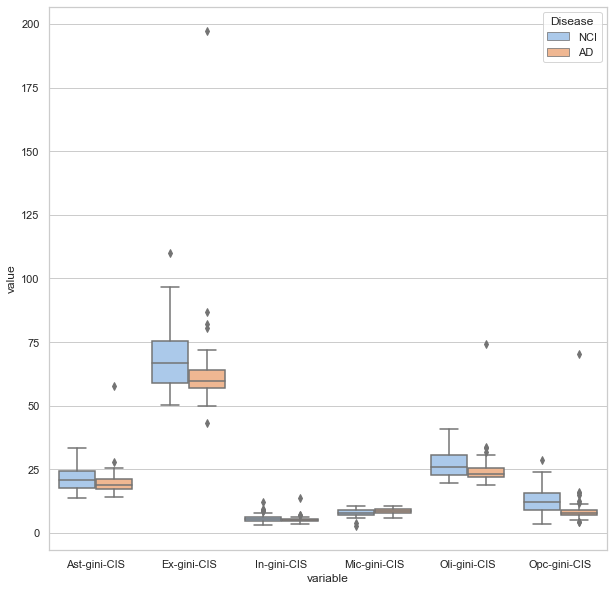

In [64]:
plt.figure(figsize = (10, 10))
sns.boxplot(data = meltADCIS, x = "variable",
           y = "value", hue = "Disease")

In [65]:
meltADCIS.shape

(948, 12)

In [66]:
diseaseVar = []
for i in range(meltADCIS.shape[0]):
    res = meltADCIS["variable"][i] + "-" + meltADCIS["Disease"][i]
    diseaseVar += [res]

In [67]:
meltADCIS["disease_var"] = diseaseVar

In [68]:
kyOnly = meltADCIS[meltADCIS["Center"] == "University of Kentucky"]

In [69]:
test = kyOnly[kyOnly["variable"] == "Ast-gini-CIS"]

In [70]:
test = test.drop_duplicates(subset = "Isolate", keep = "first")

In [71]:
np.unique(test['Disease'], return_counts = True)

(array(['AD', 'NCI'], dtype=object), array([40, 18]))

In [72]:
disease_pal = {}
for i in np.unique(kyOnly["disease_var"]):
    if "AD" in i: disease_pal[i] = "#cae9ff"
    else: disease_pal[i] = "#5FA8D3"

In [73]:
goodCells = ["Ast-gini-CIS", "Ex-gini-CIS", "Oli-gini-CIS", "Opc-gini-CIS"]

In [74]:
kyGoodCell = kyOnly[kyOnly["variable"].isin(goodCells)]

In [75]:
cogFn = []
for i in kyGoodCell["MMSE"]:
    i = int(i)
    if i >= 24: cogFn += ["Normal"]
    elif 19 <= i < 24: cogFn += ["Mild Dementia"]
    elif 10 <= i < 19: cogFn += ["Moderate Dementia"]
    else: cogFn += ["Severe Dementia"]

In [76]:
kyGoodCell["mmseCategory"] = cogFn

/Users/kayaneh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


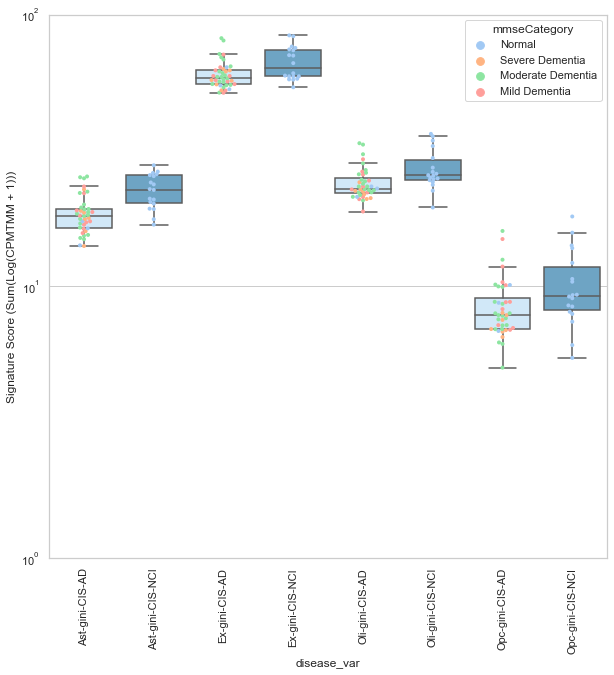

In [77]:
plt.figure(figsize = (10, 10))
plt.semilogy()

sns.boxplot(data = kyGoodCell, x = "disease_var",
           y = "value", 
            #hue = "Disease",
           palette = disease_pal,
            fliersize = 0)

sns.swarmplot(data = kyGoodCell, x = "disease_var",
              hue = "mmseCategory",
              y = "value", size = 4)

plt.ylabel("Signature Score (Sum(Log(CPMTMM + 1)))")
plt.ylim((1, 100))
plt.xticks(rotation = "90");

In [78]:
desOrder = ['Ast-gini-CIS-NCI', 'Ast-gini-CIS-AD', 
            'Ex-gini-CIS-NCI', 'Ex-gini-CIS-AD',
           'Oli-gini-CIS-NCI', 'Oli-gini-CIS-AD',
           'Opc-gini-CIS-NCI', 'Opc-gini-CIS-AD']

In [80]:
kyGoodCell[kyGoodCell["variable"] == "Ast-gini-CIS"]['']

,Gender,Center,Disease,MMSE,CDR,Expt ID,Vol (ul),plasma equiv (ul),Sequencing run,Isolate,variable,value,disease_var,mmseCategory
22,Female,University of Kentucky,AD,25,1,AD4,1000,333.000000,1,2426,Ast-gini-CIS,14.170507,Ast-gini-CIS-AD,Normal
23,Male,University of Kentucky,AD,4,3,AD5,1000,333.000000,1,2497,Ast-gini-CIS,22.769593,Ast-gini-CIS-AD,Severe Dementia
24,Male,University of Kentucky,AD,7,3,AD6,1000,333.000000,1,2498,Ast-gini-CIS,18.695136,Ast-gini-CIS-AD,Severe Dementia
25,Female,University of Kentucky,AD,14,2,AD16,1000,333.000000,1,2499,Ast-gini-CIS,25.231557,Ast-gini-CIS-AD,Moderate Dementia
26,Female,University of Kentucky,AD,20,1,AD17,700,333.000000,1,2500,Ast-gini-CIS,23.334176,Ast-gini-CIS-AD,Mild Dementia
27,Female,University of Kentucky,AD,23,2,AD18,1000,333.000000,1,2502,Ast-gini-CIS,22.035908,Ast-gini-CIS-AD,Mild Dementia
28,Female,University of Kentucky,AD,17,1,AD28,1000,333.000000,1,2503,Ast-gini-CIS,19.524729,Ast-gini-CIS-AD,Moderate Dementia
29,Female,University of Kentucky,AD,17,2,AD29,1000,333.000000,1,2504,Ast-gini-CIS,22.084003,Ast-gini-CIS-AD,Moderate Dementia
30,Male,University of Kentucky,AD,24,0.5,AD30,1000,333.000000,1,2513,Ast-gini-CIS,16.364611,Ast-gini-CIS-AD,Normal
31,Female,University of Kentucky,AD,17,2,AD40,1000,333.000000,2,2514,Ast-gini-CIS,16.472812,Ast-gini-CIS-AD,Moderate Dementia


([<matplotlib.axis.YTick at 0x7ff4633baf28>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

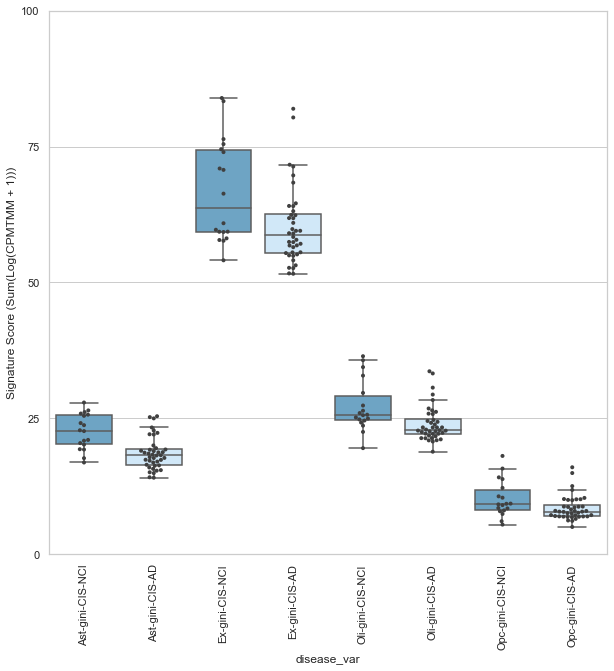

In [46]:
plt.figure(figsize = (10, 10))

sns.boxplot(data = kyGoodCell, x = "disease_var",
           y = "value", 
           palette = disease_pal,
            order = desOrder,
            fliersize = 0)

sns.swarmplot(data = kyGoodCell, x = "disease_var",
              color = "0.25",
              order = desOrder,
              y = "value", size = 4)

plt.ylabel("Signature Score (Sum(Log(CPMTMM + 1)))")

plt.ylim((0, 100))

plt.xticks(rotation = "90");
plt.yticks(np.arange(0, 101, 25))
#save_figure_pdf(plt, "ad_sigScore_astExOliOpc_09082021.pdf")

In [47]:
with pd.ExcelWriter(sourceDataPath, mode = 'a') as writer:
            kyGoodCell[['Center', 'Disease', 'Isolate', 'variable', 'value', 'disease_var']].to_excel(writer, sheet_name = 'AD', engine = 'xlsxwriter')

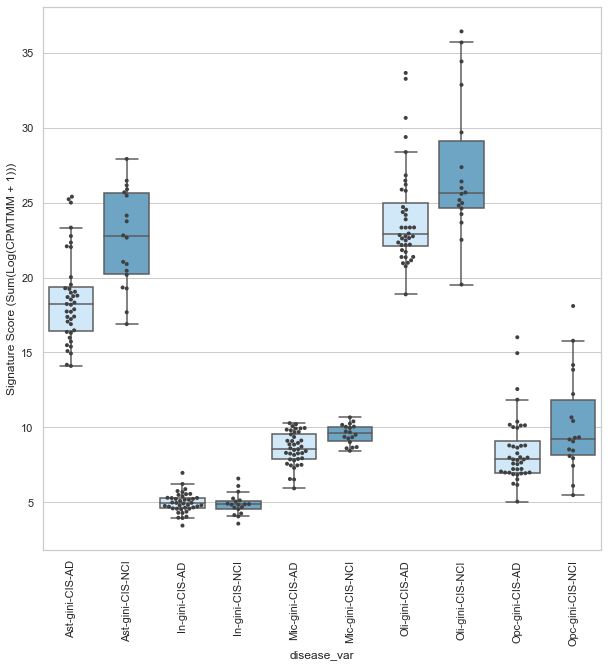

In [47]:
noEx = kyOnly[kyOnly["variable"] != "Ex-gini-CIS"]
plt.figure(figsize = (10, 10))
sns.boxplot(data = noEx, x = "disease_var",
           y = "value", fliersize = 0, palette = disease_pal)
sns.swarmplot(data = noEx, x = "disease_var",
           y = "value", color = "0.25", size = 4)
plt.ylabel("Signature Score (Sum(Log(CPMTMM + 1)))");
plt.xticks(rotation = "90");

In [59]:
cellTypeUVals = {}
for celltype in np.unique(kyOnly["variable"]):
    ctCIS = kyOnly[kyOnly["variable"] == celltype]
    adList = ctCIS[ctCIS["Disease"] == "AD"]["value"].tolist()
    nciList = ctCIS[ctCIS["Disease"] == "NCI"]["value"].tolist()
    if celltype == "Ex-gini-CIS":
        u, p = mannwhitneyu(adList, nciList, alternative = "less")
    else: 
        u, p = mannwhitneyu(adList, nciList, alternative = "two-sided")
    cellTypeUVals[celltype] = u
    print(celltype, u, p)

Ast-gini-CIS 121.0 6.109402446976773e-05
Ex-gini-CIS 206.0 0.004941116975336617
In-gini-CIS 391.0 0.6082149618243848
Mic-gini-CIS 170.0 0.0014476080728198192
Oli-gini-CIS 178.0 0.0022843947135658595
Opc-gini-CIS 224.0 0.02276286699352783


In [49]:
# now perform the permutation test

In [50]:
"""np.random.seed(10)

pValDict = {}
differenceDict = {}
uDict = {}
for celltype in np.unique(kyOnly["variable"]):
    print(celltype)
    ctCIS = kyOnly[kyOnly["variable"] == celltype]
    
    pvals = []
    difference = []
    uList = []
    for i in range(10000):
        newLabels = np.random.permutation(ctCIS["Disease"])
        
        ctCIS['shuffled'] = newLabels


        ad = ctCIS[ctCIS['shuffled'] == "AD"]['value'].values.tolist()
        nci = ctCIS[ctCIS['shuffled'] == "NCI"]["value"].values.tolist()

        u_permute, p_permute = mannwhitneyu(nci, ad, alternative = "greater")
        
        
        difference += [np.mean(nci) - np.mean(ad)]
        uList += [u_permute]
        pvals += [p_permute]
        
    pValDict[celltype] = pvals
    differenceDict[celltype] = difference
    uDict[celltype] = uList"""

'np.random.seed(10)\n\npValDict = {}\ndifferenceDict = {}\nuDict = {}\nfor celltype in np.unique(kyOnly["variable"]):\n    print(celltype)\n    ctCIS = kyOnly[kyOnly["variable"] == celltype]\n    \n    pvals = []\n    difference = []\n    uList = []\n    for i in range(10000):\n        newLabels = np.random.permutation(ctCIS["Disease"])\n        \n        ctCIS[\'shuffled\'] = newLabels\n\n\n        ad = ctCIS[ctCIS[\'shuffled\'] == "AD"][\'value\'].values.tolist()\n        nci = ctCIS[ctCIS[\'shuffled\'] == "NCI"]["value"].values.tolist()\n\n        u_permute, p_permute = mannwhitneyu(nci, ad, alternative = "greater")\n        \n        \n        difference += [np.mean(nci) - np.mean(ad)]\n        uList += [u_permute]\n        pvals += [p_permute]\n        \n    pValDict[celltype] = pvals\n    differenceDict[celltype] = difference\n    uDict[celltype] = uList'

In [53]:
np.random.seed(10)

pValDict = {}
differenceDict = {}
uDict = {}
for celltype in np.unique(kyOnly["variable"]):
    print(celltype)
    ctCIS = kyOnly[kyOnly["variable"] == celltype]
    
    pvals = []
    difference = []
    uList = []
    for i in range(10000):
        newLabels = np.random.permutation(ctCIS["Disease"])
        
        ctCIS['shuffled'] = newLabels


        ad = ctCIS[ctCIS['shuffled'] == "AD"]['value'].values.tolist()
        nci = ctCIS[ctCIS['shuffled'] == "NCI"]["value"].values.tolist()
            
        if celltype == "Ex-gini-CIS":
            u_permute, p_permute = mannwhitneyu(ad, nci, alternative = "less")
        else:
            u_permute, p_permute = mannwhitneyu(nci, ad, alternative = "two-sided")
        
        
        difference += [np.mean(nci) - np.mean(ad)]
        uList += [u_permute]
        pvals += [p_permute]
        
    pValDict[celltype] = pvals
    differenceDict[celltype] = difference
    uDict[celltype] = uList

Ast-gini-CIS


/Users/kayaneh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Ex-gini-CIS
In-gini-CIS
Mic-gini-CIS
Oli-gini-CIS
Opc-gini-CIS


In [60]:
cellTypeUVals

{'Ast-gini-CIS': 121.0,
 'Ex-gini-CIS': 206.0,
 'In-gini-CIS': 391.0,
 'Mic-gini-CIS': 170.0,
 'Oli-gini-CIS': 178.0,
 'Opc-gini-CIS': 224.0}

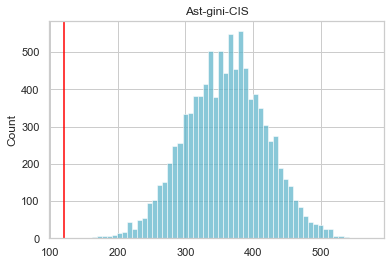

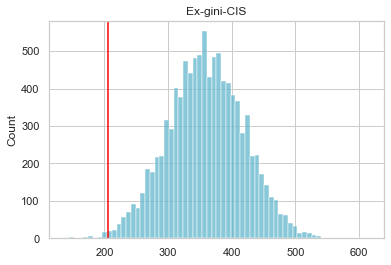

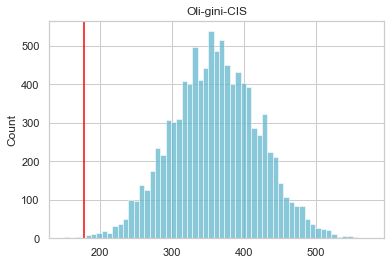

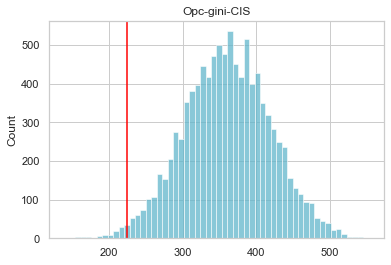

In [62]:
for i in uDict:
    if "Ast" in i or "Ex" in i or "Oli" in i or "Opc" in i:
        sns.histplot(uDict[i], color = "#62B6CB")
        plt.axvline(x = cellTypeUVals[i], color = "red")
        plt.title(i)
        save_figure_pdf(plt, i + '-uDistUnderNull.pdf')
        plt.show()

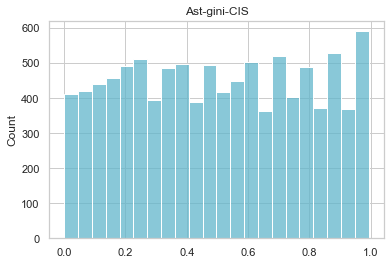

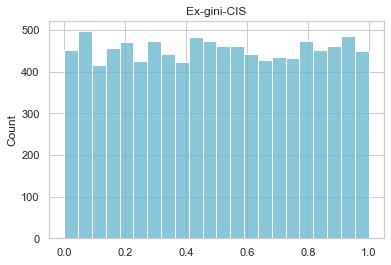

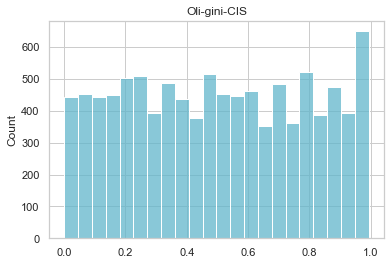

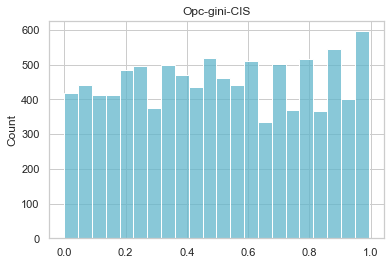

In [63]:
for i in pValDict:
    if "Ast" in i or "Ex" in i or "Oli" in i or "Opc" in i:
        sns.histplot(pValDict[i], color = "#62B6CB")
        
        plt.title(i)
        save_figure_pdf(plt, i + '_pvalDist.pdf')
        plt.show()

# other plots

/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 71.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 37.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 59.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/cat

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Ast-gini-CIS-NCI'),
  Text(1, 0, 'Ast-gini-CIS-AD'),
  Text(2, 0, 'Ex-gini-CIS-NCI'),
  Text(3, 0, 'Ex-gini-CIS-AD'),
  Text(4, 0, 'In-gini-CIS-NCI'),
  Text(5, 0, 'In-gini-CIS-AD'),
  Text(6, 0, 'Mic-gini-CIS-NCI'),
  Text(7, 0, 'Mic-gini-CIS-AD'),
  Text(8, 0, 'Oli-gini-CIS-NCI'),
  Text(9, 0, 'Oli-gini-CIS-AD'),
  Text(10, 0, 'Opc-gini-CIS-NCI'),
  Text(11, 0, 'Opc-gini-CIS-AD')])

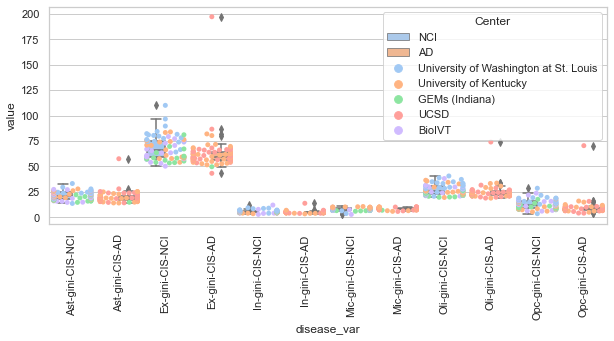

In [54]:
plt.figure(figsize = (10, 4))
sns.boxplot(data = meltADCIS, x = "disease_var", y = "value", hue = "Disease")
sns.swarmplot(data = meltADCIS, x = "disease_var", y = "value", hue = "Center")
plt.xticks(rotation = "90")

<AxesSubplot:xlabel='variable', ylabel='value'>

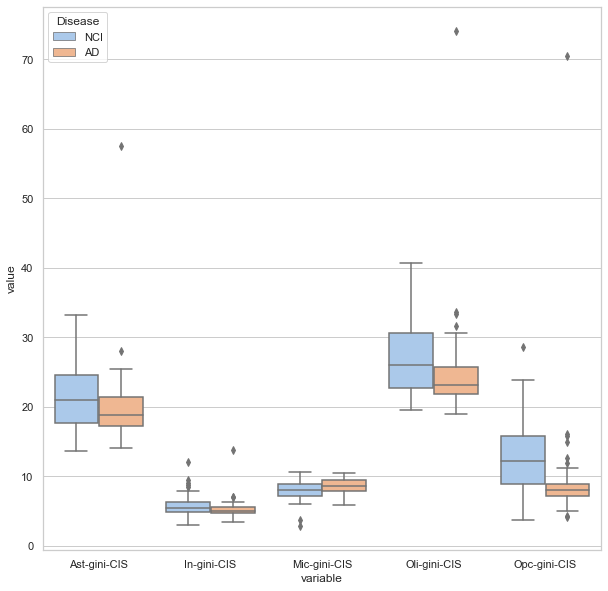

In [55]:
noEx = meltADCIS[meltADCIS["variable"] != "Ex-gini-CIS"]
plt.figure(figsize = (10, 10))
sns.boxplot(data = noEx, x = "variable",
           y = "value", hue = "Disease")

/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 33.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 74.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 70.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/cat

<AxesSubplot:xlabel='variable', ylabel='value'>

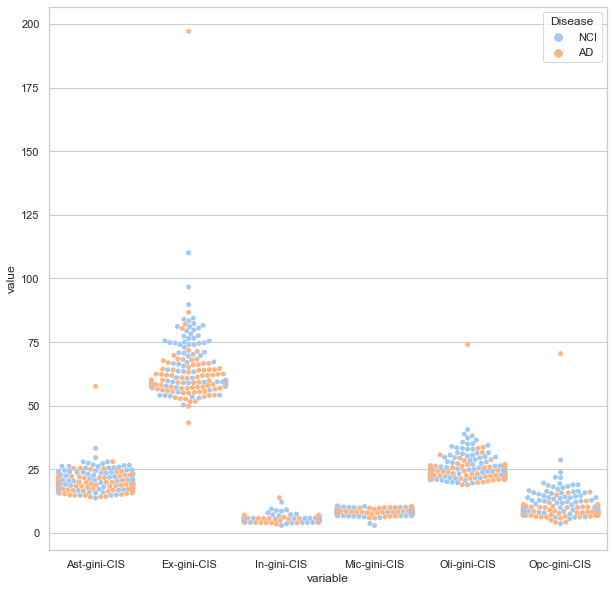

In [56]:
plt.figure(figsize = (10, 10))
sns.swarmplot(data = meltADCIS, x = "variable",
           y = "value", hue = "Disease")

/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 33.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 74.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 70.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kayaneh/anaconda3/lib/python3.6/site-packages/seaborn/cat

<AxesSubplot:xlabel='variable', ylabel='value'>

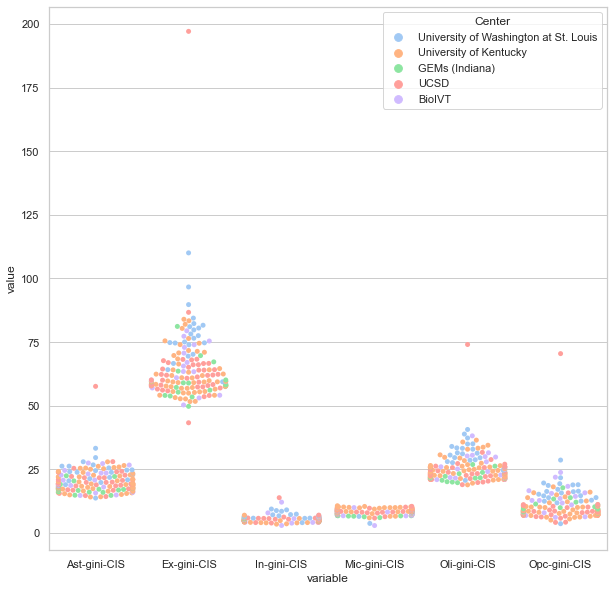

In [57]:
plt.figure(figsize = (10, 10))
sns.swarmplot(data = meltADCIS, x = "variable",
           y = "value", hue = "Center")